In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import integrate
from scipy import interpolate
import math
from scipy import signal
from numba import jit
%run StreamClass.ipynb
%run KalmanFilter.ipynb

## Plot each variable on a graph

Parsed File
Freq. of Acceleration 190.0300697928473
Freq. of Lin. Acceleration 49.00211454776328
Freq. of Gyroscope 52.67300802601869
Interpolated Samples
Rotated Acceleration
Integrated Acceleration
Loaded Ground Truth
Aligned Ground Truth
(1197, 4)


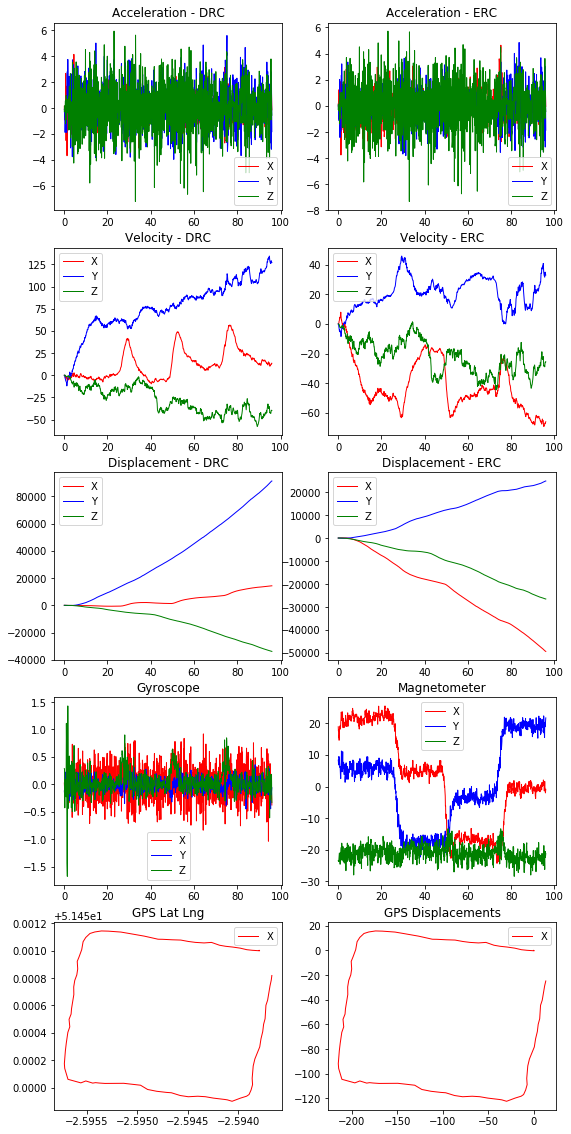

In [2]:
data = Data_Stream("data5.csv", load_truth=True)
print(data.acc_DRC.shape)
data.plot()

## Kalman Filter Implementation

In [3]:
# %lprun -f compute_kalman(data)
# compute_kalman(data, reverse=True)

compute_kalman(data, acc_stddev=1.73)
compute_kalman(data, reverse=True, acc_stddev=1.73)
# %lprun -T lprof0 -f compute_kalman compute_kalman(data)
# %cat lprof0
mean_kal = (data.kal_latlng + data.kal_latlng_reverse)/2.0

<IPython.core.display.Javascript object>


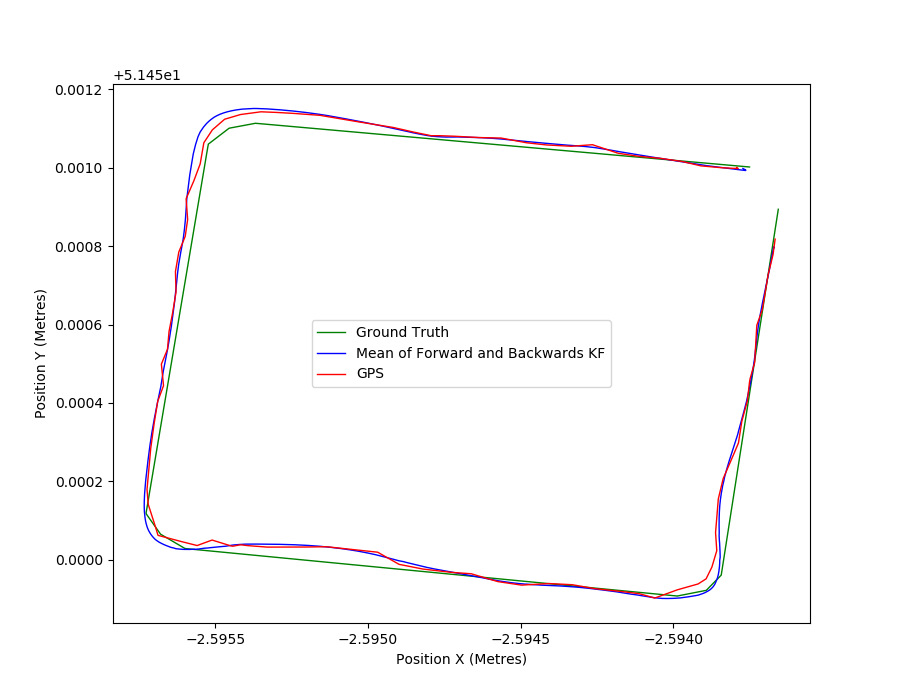

In [4]:
%matplotlib notebook
plt.figure(figsize=(9, 7))
ax=plt.subplot(111)
plt.plot(data.ground_truth.latlngs[:, 1], data.ground_truth.latlngs[:, 2], 'g-', lw=1, label='Ground Truth')
# plt.plot(data.kal_latlng[:, 1], data.kal_latlng[:, 2], 'b-', lw=1, label='Forward')
# plt.plot(data.kal_latlng_reverse[:, 1], data.kal_latlng_reverse[:, 2], 'c-', lw=1, label='Backward')
plt.plot(mean_kal[:, 1], mean_kal[:, 2], 'b-', lw=1, label='Mean of Forward and Backwards KF')
plt.plot(data.gps_latlng[:, 1], data.gps_latlng[:, 2], 'r-', lw=1, label='GPS')
plt.xlabel('Position X (Metres)')
plt.ylabel('Position Y (Metres)')
ax.legend()

Plot Kalman Filter output against original Sensor Input

## Plotting Overlay on Google Maps
https://www.geeksforgeeks.org/python-plotting-google-map-using-gmplot-package/

https://github.com/pbugnion/gmaps

https://jupyter-gmaps.readthedocs.io/en/latest/

In [5]:
import gmaps
import gmaps.datasets

f = open('apikey.txt')
a = f.readline()

gmaps.configure(api_key=a) # Your Google API key

f_layout = {'width': '900px','height': '800px','border': '1px solid black', 'padding': '1px'}
fig = gmaps.figure(layout = f_layout, center=(data.kal_latlng[0, 2], 
                                              data.kal_latlng[0, 1]), zoom_level=18, map_type='HYBRID')
lines = []

# locations_kal = gmaps.heatmap_layer([(i[0, 2], i[0, 1]) for i in data.kal_latlng])
# locations_kal.gradient = [(0, 0, 0, 0.0), (0, 0, 255, 1), (0, 0, 128, 1)]
# locations_kal.max_intensity = 1
# locations_kal.point_radius = 5
# print("Kalman Heatmap Layer")

# locations_kal_rev = gmaps.heatmap_layer([(i[0, 2], i[0, 1]) for i in data.kal_latlng_reverse])
# locations_kal_rev.gradient = [(0, 0, 0, 0.0), (0, 255, 255, 1), (0, 128, 128, 1)]
# locations_kal_rev.max_intensity = 1
# locations_kal_rev.point_radius = 5
# print("Kalman Reverse Heatmap Layer")

locations_mean_kal = gmaps.heatmap_layer([(i[0, 2], i[0, 1]) for i in mean_kal])
locations_mean_kal.gradient = [(0, 0, 0, 0.0), (255, 0, 255, 1), (128, 0, 255, 1)]
locations_mean_kal.max_intensity = 1
locations_mean_kal.point_radius = 5
print("Kalman Mean Heatmap Layer")


locations_gps = gmaps.heatmap_layer([(i[0, 2], i[0, 1]) for i in data.gps_latlng])
locations_gps.gradient = [(0, 0, 0, 0.0), (255, 0, 0, 1), (128, 0, 0 , 1)]
locations_gps.max_intensity = 1
locations_gps.point_radius = 5
print("GPS Heatmap Layer")


locations_gt = gmaps.heatmap_layer([(i[0, 2], i[0, 1]) for i in data.ground_truth.latlngs])
locations_gt.gradient = [(0, 0, 0, 0.0), (0, 255, 0, 1), (0, 128, 0 , 1)]
locations_gt.max_intensity = 1
locations_gt.point_radius = 5
print("Ground Truth Heatmap Layer")

Kalman Mean Heatmap Layer
GPS Heatmap Layer
Ground Truth Heatmap Layer


In [6]:
# fig.add_layer(locations_kal_rev)
# fig.add_layer(locations_kal)
fig.add_layer(locations_mean_kal)
fig.add_layer(locations_gps)
fig.add_layer(locations_gt)
fig

Figure(layout=FigureLayout(border='1px solid black', height='800px', padding='1px', width='900px'))

In [7]:

# compute_kalman(data, reverse=True, acc_stddev=sigma)
# print("Accuracy of Kalman Filter Backwards", measure_accuracy(data.ground_truth.dis[:, 1:3], 
#                                                           data.kal_dis_reverse[:, 1:3]))
gps_accuracy =  measure_accuracy(data.ground_truth.dis[:, 1:3], data.gps[:, 1:3])
print("Accuracy of GPS", gps_accuracy)
kal_accuracy = 500
best_sigma = -100

accs = []

sigmas = np.linspace(0.0, 3, 301)

for sigma in sigmas:
    
    compute_kalman(data, acc_stddev=sigma)
    compute_kalman(data, acc_stddev=sigma, reverse=True)
    
    mean_kal = (data.kal_dis + data.kal_dis_reverse)/2.0
    test_accuracy = measure_accuracy(data.ground_truth.dis[:, 1:3], mean_kal[:, 1:3])
    
#     print("Testing ", sigma, "Accuracy, ", test_accuracy)
    accs.append(test_accuracy)

    if(test_accuracy < kal_accuracy):
        kal_accuracy = test_accuracy
        best_sigma = sigma


print("Accuracy of Kalman Filter Mean", kal_accuracy, " at ", best_sigma)

print("Percentage Improvement", 1-kal_accuracy/gps_accuracy)

Accuracy of GPS 23.667116088385338
Accuracy of Kalman Filter Mean 23.518701096753688  at  0.4
Percentage Improvement 0.00627093690153846


<IPython.core.display.Javascript object>


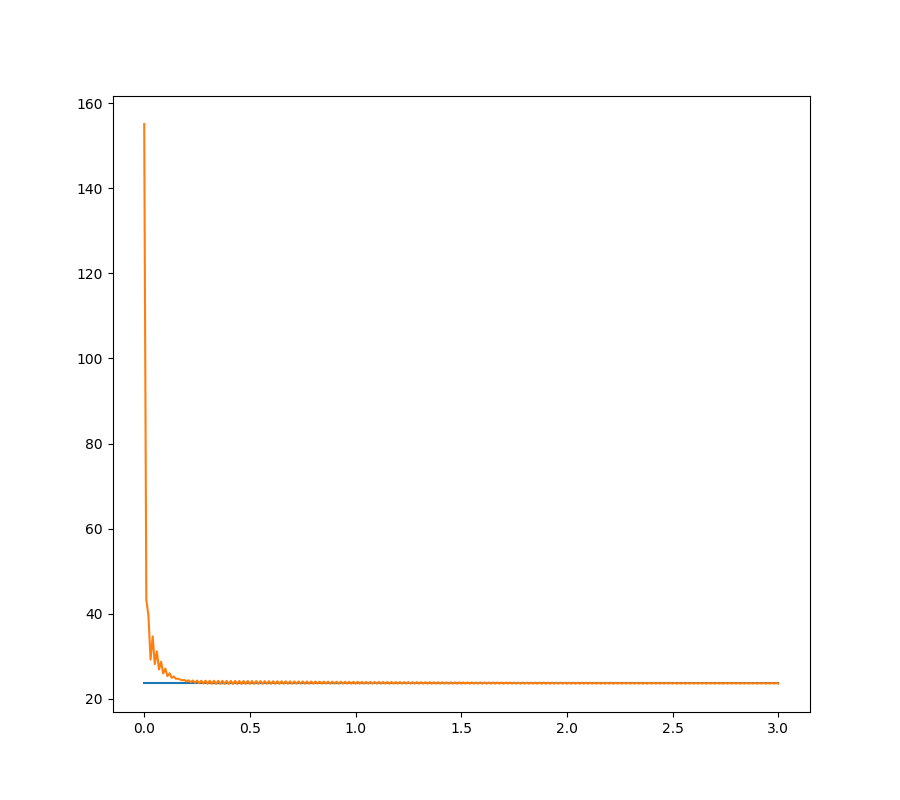

In [8]:
plt.figure(figsize=(9, 8))
ax=plt.subplot(111)
plt.plot(sigmas, [gps_accuracy for i in accs])
plt.plot(sigmas, accs)